# Data Input
## Load Attributes

In [1]:
import os
import sys
sys.path.append("../")
from src.data_input import load_attributes

example_csv = f"../examples/example_input.csv"
subgroup_information = {"sex":["M","F"], "COVID_positive":["Yes",'No']}
df = load_attributes(example_csv, subgroup_information=subgroup_information, rel_path=os.path.dirname(os.getcwd()))
print(df.head())

                                                Path sex COVID_positive
0  /home/alexis.burgon/code/RST_Decision_Region_A...   F             No
1  /home/alexis.burgon/code/RST_Decision_Region_A...   M             No
2  /home/alexis.burgon/code/RST_Decision_Region_A...   M             No
3  /home/alexis.burgon/code/RST_Decision_Region_A...   M            Yes
4  /home/alexis.burgon/code/RST_Decision_Region_A...   M            Yes


## Load Image(s)

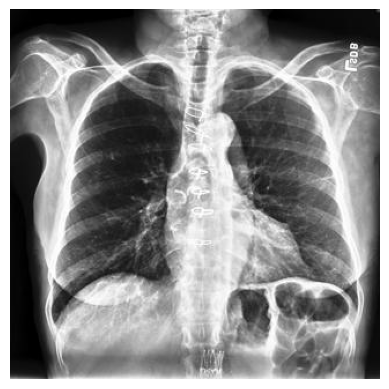

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
from src.data_input import load_image

img_arr = load_image(df.at[0, 'Path'])
plt.imshow(Image.fromarray(img_arr))
plt.axis('off')
plt.show()

# Generate Vicinal Distribution

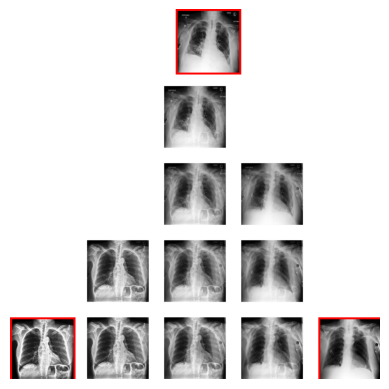

In [3]:
# Vicinal distribution generation
from src import vicinal_distribution
import matplotlib.pyplot as plt
## create a plane dataset -> ex. using the first 3 images in the dataframe
pds = vicinal_distribution.plane_dataset(load_image(df.at[0,'Path']), load_image(df.at[1,'Path']), load_image(df.at[2,'Path']), steps=5, shape='triangle')
## View virtual images
vicinal_dist_img = pds.view_vicinal(background='white', border_original=True)
plt.imshow(vicinal_dist_img)
plt.axis('off')
plt.show()

## TripletManager Class

{0: {'COVID_positive': 'Yes', 'sex': 'F'}, 1: {'COVID_positive': 'Yes', 'sex': 'M'}, 2: {'COVID_positive': 'No', 'sex': 'F'}, 3: {'COVID_positive': 'No', 'sex': 'M'}}


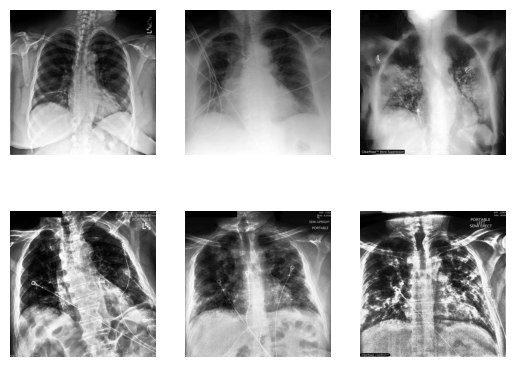

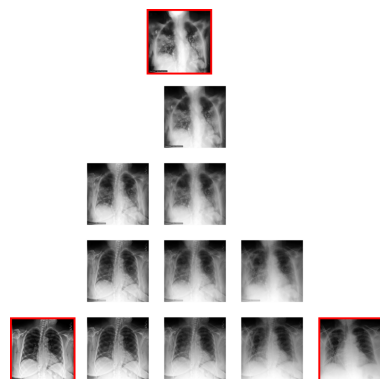

In [4]:
# TripletManager
from src.decision_region_generation import TripletManager
classes = {"COVID_positive":['Yes','No']}
subgroup_attributes = {"sex":['F','M']}
TM = TripletManager(input_csv=example_csv, classes=classes, triplets_per_group=10, subgroup_attributes=subgroup_attributes, image_rel_path=os.path.dirname(os.getcwd()))
print(TM.groups)
fig, axes = plt.subplots(2,3)
## indexing can specify group or not
triplet_0 = TM[0] # first triplet overall
for i in range(3):
    axes[0,i].imshow(Image.fromarray(triplet_0['images'][i]))
    axes[0,i].axis('off')
triplet_1 = TM[(1,1)] # triplet 1 from group 1
for i in range(3):
    axes[1,i].imshow(Image.fromarray(triplet_1['images'][i]))
    axes[1,i].axis('off')
plt.show()
# triplet manager returns images as numpy arrays -> ready to be passed to plane dataset
ds = vicinal_distribution.plane_dataset(*triplet_0['images'], shape='triangle')
vicinal_dist_img = ds.view_vicinal(background='white', border_original=True)
plt.imshow(vicinal_dist_img)
plt.axis('off')
plt.show()

# Model Deployment

In [5]:
# load onnx model
import onnx
example_model_filepath = "example_model.onnx"
model = onnx.load_model(example_model_filepath)
onnx.checker.check_model(model) # will raise an exception if not a valid model

In [28]:
# run model on vicinal distribution
import onnxruntime as ort
import numpy as np
ort_session = ort.InferenceSession(example_model_filepath, providers=ort.get_available_providers())
example_input = np.stack(triplet_0['images'])
example_input = np.transpose(example_input, (0,3,1,2)) # original model was trained on pytorch w/ images (3,320,320), for numpy the images are (320,320,3)
outputs = ort_session.run(None, {'input':example_input.astype('single')})

2023-05-19 16:29:42.121275338 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:515 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
